In [52]:
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit, Qubit, Instruction, Operation, CircuitInstruction
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.circuit.library import Barrier
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.converters import circuit_to_dag

from automation import *

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [53]:
from azure.quantum import Workspace
workspace = Workspace (
   resource_id = "/subscriptions/e0d51919-2dda-4b7e-a8e7-77cc18580acb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QECBenchmarking",
   location = "uksouth"
)

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider(workspace)
backend_est = provider.get_backend('microsoft.estimator')


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 39
             Gate count: 57
    Nonlocal gate count: 20
         Gate breakdown: RZ: 28, CX: 20, RY: 6, RX: 3


SparsePauliOp(['IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII', 'IIX', 'IXI', 'XII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])


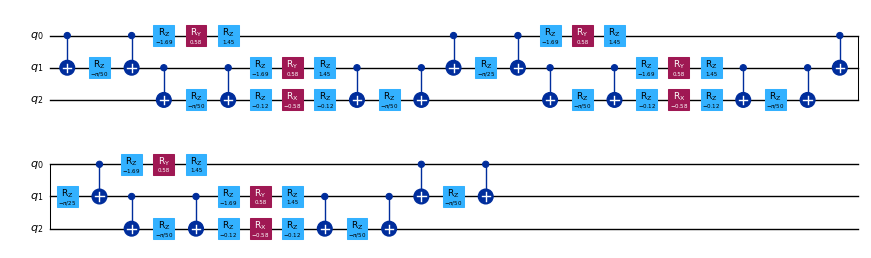

In [54]:
second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(3):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)
print(H)

circuit.draw("mpl", scale=0.5)

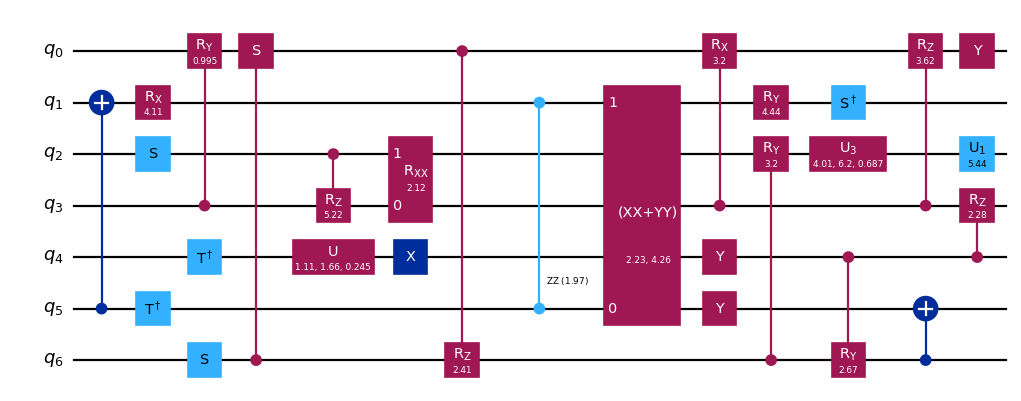

In [4]:
# from qiskit.circuit.random import random_circuit
# circuit = random_circuit(7, 6, max_operands=2, seed=1242)
# circuit.draw('mpl', scale=0.8)

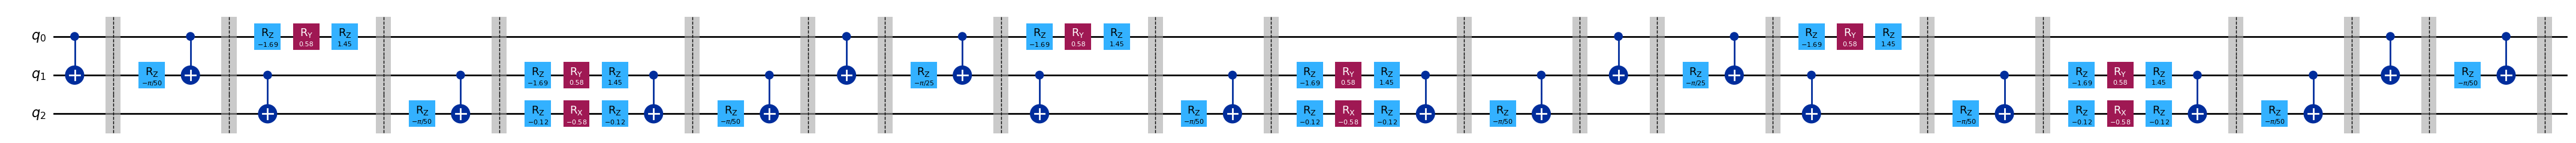

In [55]:
# target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
# transpile_circ = transpile(circuit,
#                        basis_gates=target_basis, 
#                        optimization_level=1) 
transpile_circ = circuit
_len = len(transpile_circ.data)
for index, _instr in enumerate(reversed(transpile_circ.data)):
    if _instr.operation.name == 'cx':
        transpile_circ.data.insert(_len - index, CircuitInstruction(Barrier(transpile_circ.num_qubits), range(transpile_circ.num_qubits)))

transpile_circ.draw('mpl', fold=-1)

In [56]:
# loc = {21,23,24}
loc = {7,8,9}
count = 0
ins_id = 0
p = True
for ins in transpile_circ.data:
    if ins.operation.name == 'barrier':
        count += 1
        p = True
    if count in loc and p == True:
        print(ins_id)
        p = False
    ins_id += 1
print(count)

25
28
33
20


In [57]:
# mix_circuit, ancilla = mix_cuts(RemoveBarriers()(transpile_circ), [89-23,92-24],{84-21:[6]}, gate_bell=True, wire_bell=False, ancilla=True)
mix_circuit, ancilla = mix_cuts(RemoveBarriers()(transpile_circ), [27-7],{27-7:[0], 33-9:[0]}, gate_bell=True, wire_bell=False, ancilla=True)

Found solution using 3 cuts with a samplingoverhead of 2304.
Wire Cut at circuit instruction index 20
Gate Cut at circuit instruction index 21
Wire Cut at circuit instruction index 25


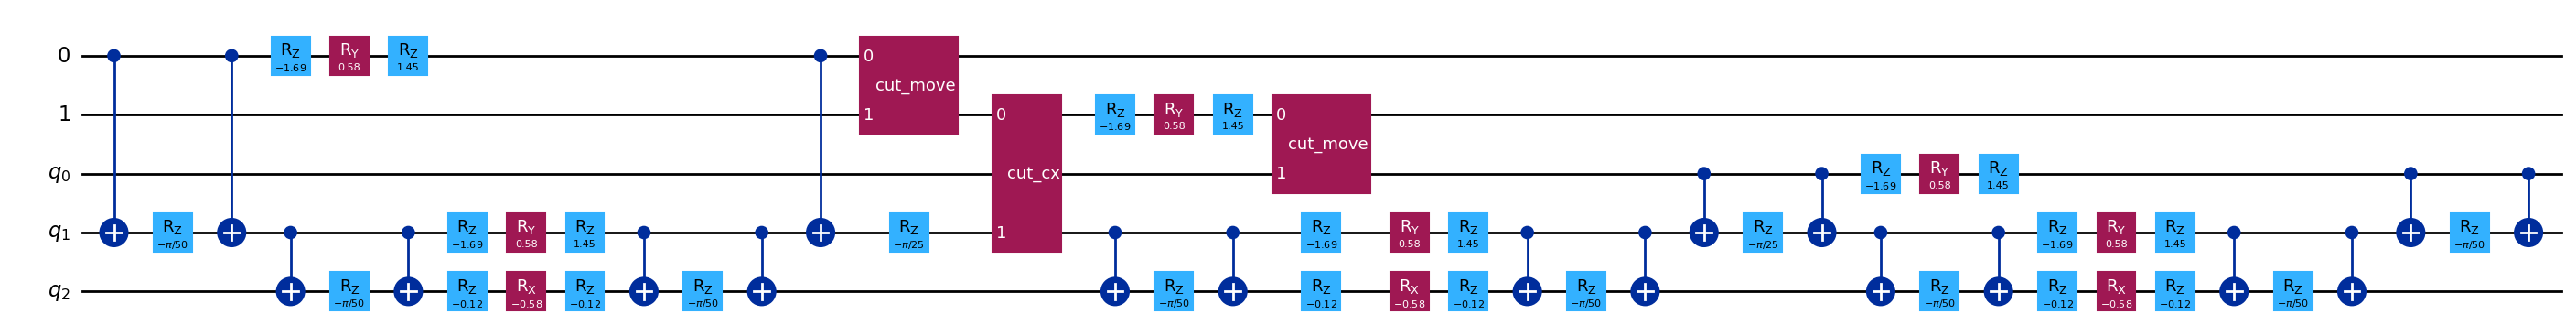

In [58]:
ancilla.draw('mpl', fold=-1)

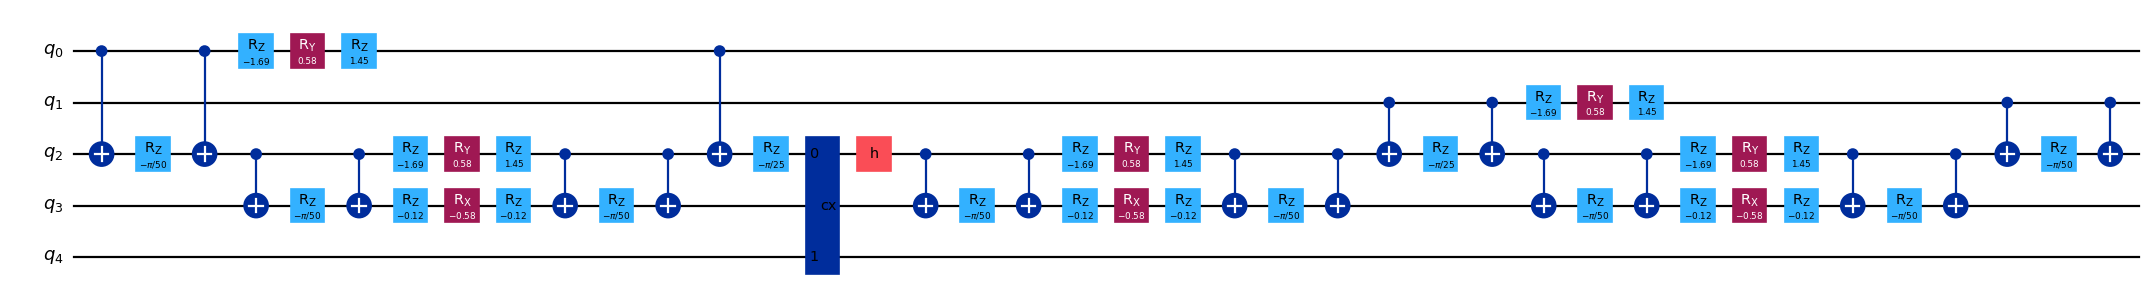

In [59]:
mix_circuit[0].draw("mpl", scale=0.8, fold=-1)

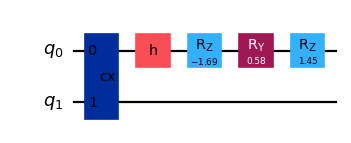

In [60]:
mix_circuit[1].draw("mpl", scale=0.8, fold=-1)

In [61]:
job = backend_est.run(circuit, errorBudget=0.01)
result = job.result()
result

.....

Runtime,1 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (3,600 nanosecs) multiplied by the 284 logical cycles to run the algorithm. If however the duration of a single T factory (here: 46,800 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,3.33M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (12) (with a logical error rate of 9.78e-7) multiplied by the clock frequency (277,777.78), which is the number of logical cycles per second."
Physical qubits,150.98k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 1,944 physical qubits to implement the algorithm logic, and 149,040 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,12,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 3$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 12$ logical qubits."
Algorithmic depth,284,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 37 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 13 multi-qubit measurements for each of the 19 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,284,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 284. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,277.78k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,481,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 13 for each of the 37 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,23,"Number of T factories capable of producing the demanded 481 T states during the algorithm's runtime The total number of T factories 23 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{481 \cdot 46,800\;\text{ns}}{1 \cdot 1,022,400\;\text{ns}}\right\rceil$"
Number of T factory invocations,21,"Number of times all T factories are invoked In order to prepare the 481 T states, the 23 copies of the T factory are repeatedly invoked 21 times."
Physical algorithmic qubits,1.94k,"Number of physical qubits for the algorithm after layout The 1,944 are the product of the 12 logical qubits after layout and the 162 physical qubits that encode a single logical qubit."


In [67]:
result.data()['physicalCounts']

{'physicalQubits': 150984,
 'runtime': 1022400,
 'rqops': 3333334,
 'breakdown': {'algorithmicLogicalQubits': 12,
  'algorithmicLogicalDepth': 284,
  'logicalDepth': 284,
  'numTstates': 481,
  'clockFrequency': 277777.77777777775,
  'numTfactories': 23,
  'numTfactoryRuns': 21,
  'physicalQubitsForTfactories': 149040,
  'physicalQubitsForAlgorithm': 1944,
  'requiredLogicalQubitErrorRate': 9.780907668231612e-07,
  'requiredLogicalTstateErrorRate': 6.9300069300069305e-06,
  'numTsPerRotation': 13,
  'cliffordErrorRate': 0.001}}

In [44]:
jobA = backend_est.run(mix_circuit[0], errorBudget=0.003)
resultA = jobA.result()
resultA

......

Runtime,1 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 300 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,4.09M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (18) (with a logical error rate of 1.85e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,207.64k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 4,356 physical qubits to implement the algorithm logic, and 203,280 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,18,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 5$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 18$ logical qubits."
Algorithmic depth,300,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 34 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 19 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,300,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 300. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,476,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 34 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,21,"Number of T factories capable of producing the demanded 476 T states during the algorithm's runtime The total number of T factories 21 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{476 \cdot 57,200\;\text{ns}}{1 \cdot 1,320,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,23,"Number of times all T factories are invoked In order to prepare the 476 T states, the 21 copies of the T factory are repeatedly invoked 23 times."
Physical algorithmic qubits,4.36k,"Number of physical qubits for the algorithm after layout The 4,356 are the product of the 18 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [45]:
jobB = backend_est.run(mix_circuit[1], errorBudget=0.007)
resultB = jobB.result()
resultB

......

Runtime,101 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (2,800 nanosecs) multiplied by the 36 logical cycles to run the algorithm. If however the duration of a single T factory (here: 36,400 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,3.21M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (9) (with a logical error rate of 7.20e-6) multiplied by the clock frequency (357,142.86), which is the number of logical cycles per second."
Physical qubits,47.92k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 882 physical qubits to implement the algorithm logic, and 47,040 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,9,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 2$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 9$ logical qubits."
Algorithmic depth,36,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 3 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 11 multi-qubit measurements for each of the 3 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,36,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 36. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,357.14k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 3 microsecs.
Number of T states,33,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 11 for each of the 3 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,12,"Number of T factories capable of producing the demanded 33 T states during the algorithm's runtime The total number of T factories 12 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{33 \cdot 36,400\;\text{ns}}{1 \cdot 100,800\;\text{ns}}\right\rceil$"
Number of T factory invocations,3,"Number of times all T factories are invoked In order to prepare the 33 T states, the 12 copies of the T factory are repeatedly invoked 3 times."
Physical algorithmic qubits,882,Number of physical qubits for the algorithm after layout The 882 are the product of the 9 logical qubits after layout and the 98 physical qubits that encode a single logical qubit.
